# NLP & train test split

In [1]:
import pandas as pd

f = open('womantalk_max.csv')
df= pd.read_csv(f, header = None)
df = df.fillna('0')

X = df.iloc[:, 2].values
y = df.iloc[:, 1].values

In [2]:
# preprocessing : extracting feature vector

import re
from zhon.hanzi import punctuation
import string

eng_punc = string.punctuation
def preprocessor(text):
    text = re.sub('\n', '', text)
    
    re_punctuation = "[{}]+".format(punctuation)  #拿掉中文標點
    text = re.sub(re_punctuation, "", text)
    
    re_punctuation_eng = "[{}]+".format(eng_punc) #拿掉英文標點
    text = re.sub(re_punctuation_eng, "", text)    
    
    ptt_punc = '\n\t ※'
    re_punctuation_ptt = "[{}]+".format(ptt_punc) #拿掉其他無用字元
    text = re.sub(re_punctuation_ptt, "", text)  
    
    text = re.sub('[0-9A-Za-z]+','',text)
    
    return text

for i in range(0, len(X)):
    X[i] = preprocessor(X[i])

In [3]:
# preprocessing : 移除stop word
import jieba.analyse
import jieba

jieba.set_dictionary("jieba_dict/dict.txt.big.txt")
tags = []

for i in range(0, len(X)):
    tags.append(jieba.analyse.extract_tags(X[i], topK=50, withWeight=True))
stopWords = []
with open('stop_word/stop_word.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)
        
X_cut = X
X_cut_stop = X

for i in range(0, len(X)):
    X_cut[i] = jieba.cut(X[i], cut_all=False)
    X_cut_stop[i] = list(filter(lambda a: a not in stopWords and a != '\n', X_cut[i]))

Building prefix dict from C:\Users\HP\Desktop\python_code\final_project_1_9\train_all_new_1_9\jieba_dict\dict.txt.big.txt ...
Loading model from cache C:\Users\HP\AppData\Local\Temp\jieba.ue61be068ea6a0a3cf972c1b0e2f6b9e9.cache
Loading model cost 2.361 seconds.
Prefix dict has been built succesfully.


In [4]:
# preprocessing : labeling y_train
# encoding of 推噓 : 
import math

for i in range(0, len(y)):
    if y[i] == '爆':
        y[i] = 3
    elif y[i][0] == 'X':
        y[i] = 0
    else:
        y[i] = int(y[i])
        if y[i] == 0:
            y[i] = 1
        elif y[i] >= 1 and y[i] <= 10:
            y[i] = 1
        elif y[i] >= 11 and y[i] <= 50:
            y[i] = 2
        elif y[i] >= 51 and y[i] <= 99:
            y[i] = 3
'''    
for i in range(0, len(y)):
    if y[i] == '爆':
        y[i] = 1
    elif y[i][0] == 'X':
        y[i] = 0
    else:
        y[i] = int(y[i])
        if y[i] == 0:
            y[i] = 0
        elif y[i] >= 1 and y[i] <= 10:
            y[i] = 0
        elif y[i] >= 11 and y[i] <= 50:
            y[i] = 1
        elif y[i] >= 51 and y[i] <= 99:
            y[i] = 1
'''

"    \nfor i in range(0, len(y)):\n    if y[i] == '爆':\n        y[i] = 1\n    elif y[i][0] == 'X':\n        y[i] = 0\n    else:\n        y[i] = int(y[i])\n        if y[i] == 0:\n            y[i] = 0\n        elif y[i] >= 1 and y[i] <= 10:\n            y[i] = 0\n        elif y[i] >= 11 and y[i] <= 50:\n            y[i] = 1\n        elif y[i] >= 51 and y[i] <= 99:\n            y[i] = 1\n"

In [5]:
# Preprocessing : 轉換成NTLK可以使用的格式
import nltk
import numpy as np

X_cut_NTLK = []

for i in range(0, len(X)):
    article = ''
    for word in X_cut_stop[i]:
        article = article + word
        article = article + ' '
    X_cut_NTLK = np.hstack((X_cut_NTLK, article))

In [6]:
from sklearn.model_selection import train_test_split

y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X_cut_NTLK, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [  35 2812  847  273]
Labels counts in y_train: [  24 1968  593  191]
Labels counts in y_test: [ 11 844 254  82]


In [7]:
# Preprocessing : Bag of Word
# Preprocessing : Term frequency - inverse document frequency (tf - idf) using NTLK
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(max_features=1000)
bag_train = count.fit_transform(X_train)
bag_test = count.transform(X_test)

tfidf = TfidfTransformer(use_idf = True,
                         norm = 'l2',
                         smooth_idf = True)
X_train = tfidf.fit_transform(bag_train)
X_test = tfidf.transform(bag_test)
print(X_train.shape[1])

1000


In [8]:
print(y.shape[0])
print(X_train.shape[0])
print(X_test.shape[0])

3967
2776
1191


In [9]:
print(len(X_train.toarray()[:,0]))
print(len(X_test.toarray()[:,0]))

X_all = np.concatenate((X_train.toarray(),X_test.toarray()),axis=0)
y_all = np.concatenate((y_train,y_test))

print(len(X_all[:,0]))
print(len(y_all))

group = np.zeros(len(y_all), dtype=np.int)
group[0:len(X_train.toarray()[:,0])] = group[0:len(X_train.toarray()[:,0])]+1
df_re = pd.DataFrame(X_all)
df_re['label'] = y_all
df_re['group'] = group

2776
1191
3967
3967


In [10]:
from sklearn.utils import resample

df_0 = df_re[df_re.group==1][df_re.label==0]
df_1 = df_re[df_re.group==1][df_re.label==1]
df_2 = df_re[df_re.group==1][df_re.label==2]
df_3 = df_re[df_re.group==1][df_re.label==3]

df_0 = resample(df_0, replace=True, n_samples=np.bincount(y_train).max(), random_state=123)
df_1 = resample(df_1, replace=True, n_samples=np.bincount(y_train).max(), random_state=123)
df_2 = resample(df_2, replace=True, n_samples=np.bincount(y_train).max(), random_state=123)
df_3 = resample(df_3, replace=True, n_samples=np.bincount(y_train).max(), random_state=123)

df_upsampled = pd.concat([df_0, df_1,df_2, df_3])

X_train_up = np.asarray(df_upsampled.iloc[:,0:1000])
y_train_up = np.asarray(df_upsampled.iloc[:,1000])
X_test_up = np.asarray(df_re[df_re.group==0].iloc[:,0:1000])
y_test_up = np.asarray(df_re[df_re.group==0].iloc[:,1000])

print('train label 分布:',np.bincount(y_train_up))
print('test label 分布:',np.bincount(y_test_up))
print('評分標準(只猜一群):',len(y_test_up[y_test_up == 2])/len(y_test_up))

c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


train label 分布: [1968 1968 1968 1968]
test label 分布: [ 11 844 254  82]
評分標準(只猜一群): 0.21326616288832914


# train model

In [11]:
# logistic regression using Scikit-learn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = 10, random_state = 1)
lr.fit(X_train_up, y_train_up)

# Prediction and Performance Measurement
y_pred = lr.predict(X_test_up)
print('Misclassified samples: %d' % (y_test_up != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test_up, y_pred))
print('Accuracy: %.2f' %lr.score(X_test_up, y_test_up))

print('\ntest --- train\n')

# Prediction and Performance Measurement
y_pred2 = lr.predict(X_train_up)
print('Misclassified samples: %d' % (y_train_up != y_pred2).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_train_up, y_pred2))
print('Accuracy: %.2f' %lr.score(X_train_up, y_train_up))

c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hp\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Misclassified samples: 625
Accuracy: 0.48
Accuracy: 0.48

test --- train

Misclassified samples: 504
Accuracy: 0.94
Accuracy: 0.94


In [12]:
print(np.bincount(y_pred))

[ 11 645 360 175]


In [13]:
j = y_pred[y_pred != 1]
k = y_test_up[y_pred != 1]

print(sum(j==k)/(len(j)+1))  ## 小群的正確率

0.1663619744058501


In [14]:
# training with SVM(RBF)
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', C = 100, gamma = 1000, random_state = 1)
svm.fit(X_train_up, y_train_up)

# Prediction and Performance Measurement
y_pred = svm.predict(X_test_up)
print('Misclassified samples: %d' % (y_test_up != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test_up, y_pred))
print('Accuracy: %.2f' %svm.score(X_test_up, y_test_up))

print('\ntest --- train\n')

# Prediction and Performance Measurement
y_pred2 = svm.predict(X_train_up)
print('Misclassified samples: %d' % (y_train_up != y_pred2).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_train_up, y_pred2))
print('Accuracy: %.2f' %svm.score(X_train_up, y_train_up))

Misclassified samples: 347
Accuracy: 0.71
Accuracy: 0.71

test --- train

Misclassified samples: 1
Accuracy: 1.00
Accuracy: 1.00


In [15]:
print(np.bincount(y_pred))

[   0 1191]


In [16]:
j = y_pred[y_pred != 1]
k = y_test_up[y_pred != 1]

print(sum(j==k)/(len(j)+1))  ## 小群的正確率

0.0


# bagging vs boosting

In [17]:
# training with forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1, n_jobs=-1)
forest.fit(X_train_up, y_train_up)

# Prediction and Performance Measurement
y_pred = forest.predict(X_test_up)
print('Misclassified samples: %d' % (y_test_up != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test_up, y_pred))
print('Accuracy: %.2f' %forest.score(X_test_up, y_test_up))

print('\ntest --- train\n')

# Prediction and Performance Measurement
y_pred2 = forest.predict(X_train_up)
print('Misclassified samples: %d' % (y_train_up != y_pred2).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_train_up, y_pred2))
print('Accuracy: %.2f' %forest.score(X_train_up, y_train_up))

Misclassified samples: 373
Accuracy: 0.69
Accuracy: 0.69

test --- train

Misclassified samples: 1
Accuracy: 1.00
Accuracy: 1.00


In [18]:
print(np.bincount(y_pred))

[   1 1151   38    1]


In [19]:
j = y_pred[y_pred != 2]
k = y_test_up[y_pred != 2]

print(sum(j==k)/(len(j)+1))  ## 小群的正確率

0.7045060658578857


In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=30, learning_rate=0.1, random_state=1)
ada = ada.fit(X_train_up,y_train_up)

# Prediction and Performance Measurement
y_pred = ada.predict(X_test_up)
print('Misclassified samples: %d' % (y_test_up != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test_up, y_pred))
print('Accuracy: %.2f' %ada.score(X_test_up, y_test_up))

print('\ntest --- train\n')

# Prediction and Performance Measurement
y_pred2 = ada.predict(X_train_up)
print('Misclassified samples: %d' % (y_train_up != y_pred2).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_train_up, y_pred2))
print('Accuracy: %.2f' %ada.score(X_train_up, y_train_up))

Misclassified samples: 651
Accuracy: 0.45
Accuracy: 0.45

test --- train

Misclassified samples: 2992
Accuracy: 0.62
Accuracy: 0.62


In [21]:
print(np.bincount(y_pred))

[  7 641 216 327]


In [22]:
j = y_pred[y_pred != 2]
k = y_test_up[y_pred != 2]

print(sum(j==k)/(len(j)+1))  ## 小群的正確率

0.5081967213114754


# nn

In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1,hidden_layer_sizes=(100, ))
mlp.fit(X_train_up, y_train_up)

# Prediction and Performance Measurement
y_pred = mlp.predict(X_test_up)
print('Misclassified samples: %d' % (y_test_up != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test_up, y_pred))
print('Accuracy: %.2f' %mlp.score(X_test_up, y_test_up))

print('\ntest --- train\n')

# Prediction and Performance Measurement
y_pred2 = mlp.predict(X_train_up)
print('Misclassified samples: %d' % (y_train_up != y_pred2).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_train_up, y_pred2))
print('Accuracy: %.2f' %mlp.score(X_train_up, y_train_up))

Misclassified samples: 586
Accuracy: 0.51
Accuracy: 0.51

test --- train

Misclassified samples: 3
Accuracy: 1.00
Accuracy: 1.00


In [24]:
print(np.bincount(y_pred))

[  6 701 368 116]


In [25]:
j = y_pred[y_pred != 2]
k = y_test_up[y_pred != 2]

print(sum(j==k)/(len(j)+1))  ## 小群的正確率

0.6310679611650486


# Word cloud analysis

In [26]:
# (Not necessary) : word cloud for training set
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = ''

for i in range(0, len(X)):
    for word in X_cut_stop[i]:
        cloud = cloud + word
        cloud = cloud + ' '

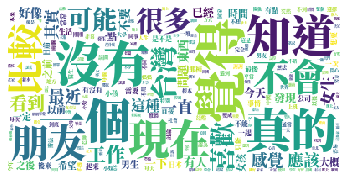

<Figure size 1000x600 with 0 Axes>

In [27]:
# 產生文字雲
wc = WordCloud(font_path="word/NotoSerifCJKtc-Black.otf", #設置字體
               background_color="white", #背景顏色
               max_words = 2000)        #文字雲顯示最大詞數
wc.generate(cloud)

# 視覺化呈現
plt.imshow(wc)
plt.axis("off")
fig = plt.figure(figsize=(10,6), dpi = 100)
plt.show()